In [1]:
from IPython.display import clear_output
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path

import adcraft.baselines.interpolated_expectations as ie
import adcraft.gymnasium_kw_env as kw_sim
from adcraft.experiment_utils.experiment_quantiles import (
    make_experiment_quantiles, load_experiment_quantiles
)
from adcraft.experiment_utils.experiment_metrics import (
    get_implicit_kw_bid_cpc_impressions, get_max_expected_bid_profits, compute_AKNCP, compute_NCP
)
import adcraft.visualization.jupyter_funcs as bvis


In [2]:
N = 30
# could put this in a look with different mean_volume/cvr values to automate experiment runs
# would need to make an experiment_csvs directory at current path for this to run
env = kw_sim.bidding_sim_creator(
    env_config=dict(
    keyword_config={
        "outer_directory": Path.cwd().as_posix()+"/experiment_csvs/",
        "mean_volume": 100,
        "conversion_rate": 0.3,
        "make_quant_func": make_experiment_quantiles,
        "load_quant_func": load_experiment_quantiles
    },
    # render_mode="ansi",
    num_keywords = N,
    max_days = 60,
    updater_params = [["vol", 0.03], ["ctr", 0.03], ["cvr", 0.03]],
    updater_mask = None#[True]*N,
))

In [3]:
obs, info = env.reset(seed = 10)

In [4]:
print(info["keyword_params"])

kw0 params:
 volume: (100, 13),   imp_intercept: 0.7386049044669925,   imp_slope: 7.3627261809468685,   bctr: 0.31804044252579394,   sctr: 0.3,   mean revenue: 0.9703987841419266,   std revenue: 0.10969622240554196
kw1 params:
 volume: (100, 31),   imp_intercept: 0.8124585400585577,   imp_slope: 4.2044508665737235,   bctr: 0.11163888030443188,   sctr: 0.3,   mean revenue: 1.0705702906229062,   std revenue: 0.03917634894645788
kw2 params:
 volume: (100, 8),   imp_intercept: 0.3221557501686997,   imp_slope: 10.852394187688585,   bctr: 0.25535694693155775,   sctr: 0.3,   mean revenue: 0.48794031199293697,   std revenue: 0.10905562626755198
kw3 params:
 volume: (100, 13),   imp_intercept: 0.6633304743341284,   imp_slope: 12.371355808003809,   bctr: 0.7229296935496455,   sctr: 0.3,   mean revenue: 0.6057705058105929,   std revenue: 0.13625750505976256
kw4 params:
 volume: (100, 33),   imp_intercept: 0.42493114913951424,   imp_slope: 20.570283754642272,   bctr: 0.24720905165502582,   sctr: 0

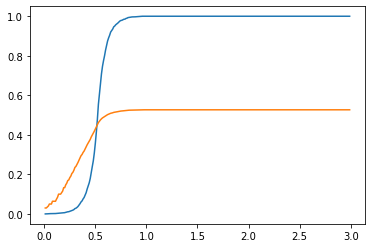

In [5]:
allowed_bids = np.arange(0.01, 3.00, 0.01)
irs, cpcs = [],[]
for kw in env.keywords:
   ir, cpc = get_implicit_kw_bid_cpc_impressions(kw, allowed_bids)
   irs.append(ir)
   cpcs.append(cpc)
plt.figure()
plt.plot(allowed_bids, ir)
# print(ir)
# print(cpc)
plt.plot(allowed_bids, cpc)
plt.show()

In [6]:
env.reset()
print(env.updater_params)
rewards = []
kw_profits = []
ideal_profits = []
actions = {"budget": 100, "keyword_bids": np.ones(N,)}
for i in range(env.max_days):
    # compute ideal profits for this timestep
    ideal_profit = []
    for kw_index, kw_params in enumerate(env.keyword_params):
        max_exp_profit, positive_proportion = get_max_expected_bid_profits(
            kw_params, cpcs[kw_index], irs[kw_index]
        )
        ideal_profit.append(max_exp_profit)
    ideal_profits.append(ideal_profit)
    
    # take action
    previous_observation, reward,_,_,info = env.step(actions)
    rewards.append(reward)
    kw_profits.append(previous_observation['revenue'] - previous_observation['cost'])

[['vol', 0.03], ['ctr', 0.03], ['cvr', 0.03]]


In [7]:
compute_AKNCP(np.array(kw_profits), np.array(ideal_profits))

-11.588435734868515

In [8]:
compute_NCP(np.array(kw_profits), np.array(ideal_profits))

-7.533635579422454

In [10]:
kw_profits = np.array(kw_profits)
ideal_profits = np.array(ideal_profits)
print(kw_profits.sum())
print(ideal_profits.sum())

-3396.1
450.7916482284046


In [11]:
def cache_tensors_to_floats(cache):
    cache["ave_rpc"] = float(cache["ave_rpc"])
    cache["ave_sctr"] = float(cache["ave_sctr"])
    cache["ave_clicks"] = {k:[float(v[0]), v[1]] for k,v in cache["ave_clicks"].items()}


def edit_rpc_cap(current_rpc_cap, rpc_rng, min_rpc_cap= 0.01):
    edit = round(rpc_rng.normal()*2)*0.01
    curent_rpc_cap += edit
    current_rpc_cap = max([round(current_rpc_cap,2), min_rpc_cap])
    return rpc_cap

def run_ie_agent(agent, budget = 1000, max_bid = 0.1, absolute_max=2.0, rpc_action_replace: bool = False, cap_rpcs: bool = False):
    allowed_bids = np.arange(0.01, max_bid+0.01, 0.01)

    # absolute_max = 2.0
    previous_observation, info = env.reset()
    previous_action = {"budget": 0.0, "keyword_bids": 0.01 + np.zeros((env.num_keywords,))}
    truncated, terminated = False, False
    rewards = [0] # used to show results at very end
    bids = [np.zeros((env.num_keywords,))]
    rpc_beliefs = []
    kw_profits = []
    ideal_profits = []
    kw_profits.append(previous_observation['revenue'] - previous_observation['cost'])
    ideal_profits.append(previous_observation['revenue'] - previous_observation['cost'])
    if cap_rpcs:
        rpc_cap = 1
        rpc_rng = np.random.default_rng(5)
    while not (terminated or truncated):
        agent.update_all_caches(previous_action, previous_observation)
        agent.allowed_bids = allowed_bids

        action = agent.sample_action()


        for i in range(env.num_keywords):
            cache_tensors_to_floats(agent.caches[i])
        rpcs = [
            max([0.01, agent.caches[ind]['ave_rpc'] * agent.caches[ind]['ave_sctr']])
            for ind in range(env.num_keywords)
        ]

        if rpc_action_replace:
            for i, cache in enumerate(agent.caches):
                if cache['num_sctr_obs'] > 2 and rpcs[i] > 0.01:
                    action["keyword_bids"][i] = round(rpcs[i], 2)

        # compute ideal profits for this timestep
        ideal_profit = []
        for kw_index, kw_params in enumerate(env.keyword_params):
            max_exp_profit, positive_proportion = get_max_expected_bid_profits(
                kw_params, cpcs[kw_index], irs[kw_index]
            )
            ideal_profit.append(max_exp_profit)
        ideal_profits.append(ideal_profit)

        
        previous_observation, reward, terminated, truncated, info = env.step(
            action = {"budget": budget, "keyword_bids": action["keyword_bids"]}
        )
                
        previous_action = action
        if cap_rpcs:
            previous_observation['revenue'] = np.fmin(
                previous_observation['revenue'], 
                rpc_cap*previous_observation['sellside_conversions']
            )
            rpc_cap = edit_rpc_cap(rpc_cap, rpc_rng, 0.05)

        
        max_bid += 0.03
        max_bid = min([max_bid, absolute_max])
        allowed_bids = np.arange(0.01, max_bid+0.01, 0.01)

        bids.append(action["keyword_bids"])
        kw_profits.append(previous_observation['revenue'] - previous_observation['cost'])
        rewards.append(np.sum(previous_observation['revenue'] - previous_observation['cost']))
        rpc_beliefs.append(rpcs)

        bvis.show_keyword_profits(kw_profits, bids)
        bvis.show_cumulative_rewards(rewards)
    return np.array(kw_profits), np.array(ideal_profits)

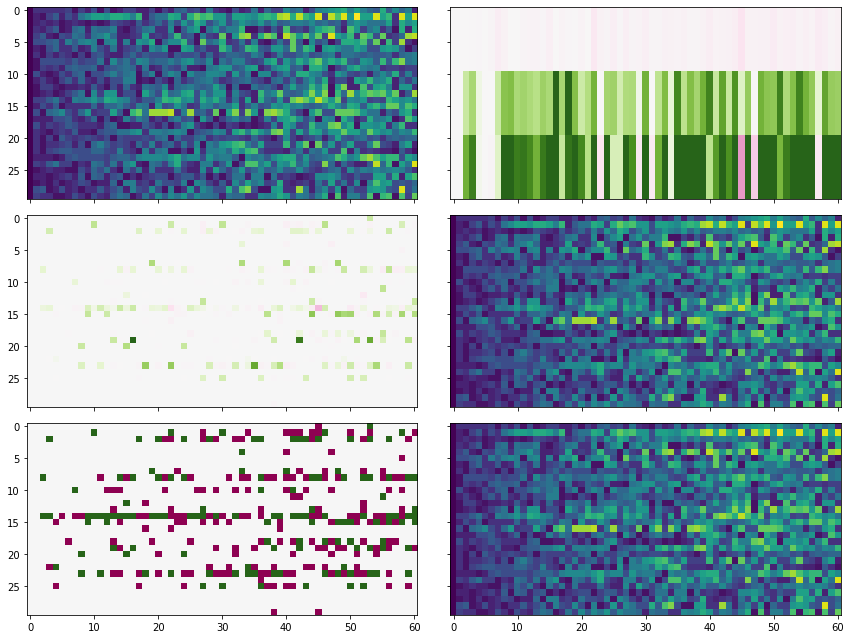

total rewards: 83.50000000000001
max rewards per timestep: 4.23
min rewards per timestep: -0.7000000000000002
mean rewards per time step 1.3688524590163937
std dev rewards per time step 1.137820894546995


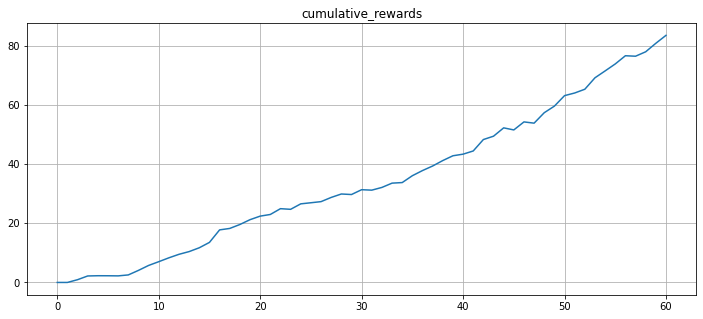

In [12]:
agent = ie.NaiveInterpolationStrategy(
    env.num_keywords, 
    profit_acquisition_threshold=-0.1, 
    allowed_bids = np.arange(0.01, 0.1+0.01, 0.01)
)

kw_profits, ideal_profits = run_ie_agent(agent, rpc_action_replace = False, max_bid = 0.1, absolute_max = 3.0)

In [13]:
compute_AKNCP(kw_profits, ideal_profits)

0.148370018733237

In [14]:
compute_NCP(kw_profits, ideal_profits)

0.1852296960872103

In [15]:
print(ideal_profits.sum()/env.max_days)
print(kw_profits.sum()/env.max_days)

7.513194137140077
1.3916666666666666


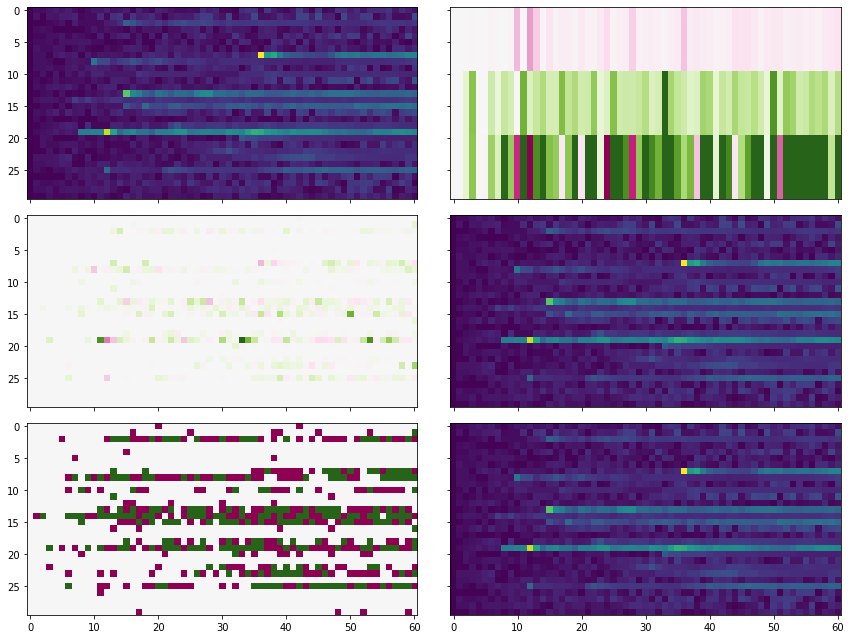

total rewards: 113.02999999999999
max rewards per timestep: 7.859999999999999
min rewards per timestep: -4.379999999999997
mean rewards per time step 1.852950819672131
std dev rewards per time step 2.2571818671050528


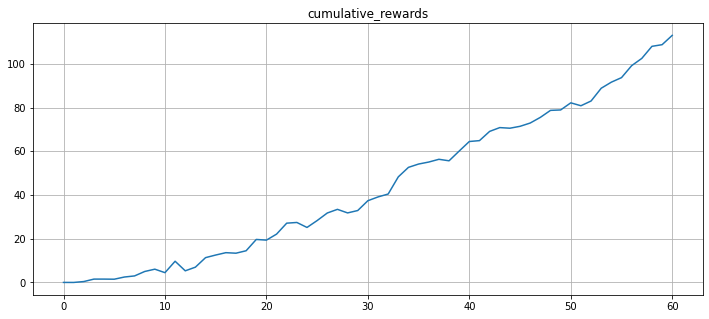

In [16]:
agent = ie.NaiveInterpolationStrategy(
    env.num_keywords, 
    profit_acquisition_threshold=-0.1, 
    allowed_bids = np.arange(0.01, 0.1+0.01, 0.01)
)

kw_profits2, ideal_profits2 = run_ie_agent(agent, rpc_action_replace = True, max_bid = 0.1, absolute_max = 3.0)

In [17]:
compute_AKNCP(kw_profits2, ideal_profits2)

0.0722195066545739

In [18]:
compute_NCP(kw_profits2, ideal_profits2)

0.2507366772303878

In [20]:
print(ideal_profits2.sum()/env.max_days)
print(kw_profits2.sum()/env.max_days)

7.513194137140077
1.8838333333333332
